In [ ]:
from langchain.llms import AzureOpenAI
import openai
from dotenv import load_dotenv
import os
from IPython.display import display, HTML
import json

In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") 
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_DEPLOYMENT_NAME = os.getenv("OPENAI_DEPLOYMENT_NAME")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv("OPENAI_EMBEDDING_DEPLOYMENT_NAME")
OPENAI_EMBEDDING_MODEL_NAME = os.getenv("OPENAI_EMBEDDING_MODEL_NAME")
OPENAI_DEPLOYMENT_VERSION = os.getenv("OPENAI_DEPLOYMENT_VERSION")

# Configure OpenAI API
openai.api_type = "azure"
openai.api_version = OPENAI_DEPLOYMENT_VERSION
openai.api_base = OPENAI_DEPLOYMENT_ENDPOINT
openai.api_key = OPENAI_API_KEY

### **Model Initialization**

In [ ]:
def init_llm(model="text-davinci-003",
             deployment_name="text-davinci-003", 
             temperature=0,
             max_tokens=3000,
             stop="<|im_end|>", 
             ):
    
    llm = AzureOpenAI(deployment_name=deployment_name,  
                  model=model,
                  temperature=temperature,) 
    return llm

In [ ]:
#Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
llm=init_llm()
embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDING_MODEL_NAME)

In [51]:
from langchain.document_loaders import PyPDFLoader

large_pdf_path ="./data/NeurIPS-2020-language-models-are-few-shot-learners-Paper.pdf"
loader = PyPDFLoader(large_pdf_path)

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)
pages = loader.load_and_split(text_splitter=text_splitter)

document_vectors=[]
for page in pages:
    document_vectors.append(embeddings.embed_documents([page.page_content], chunk_size=1)[0] )     

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 10 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 6 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_C

In [52]:
print("Document vectors shape: ", np.array(document_vectors).shape)

Document vectors shape:  (32, 1536)


In [53]:
print(document_vectors)

[[-0.012792802641945024, -0.0020704323326247954, 0.03693870520328511, -0.009268954560108561, 0.00864508297676379, 0.026586544238653077, 0.005666265829985533, 0.021074531972444206, -0.0318928813612027, -0.054818463549547586, 0.03515621336860418, 0.03194772881123657, -0.027518922949551175, -0.004795587240746473, 0.021622991571621474, 0.016549745867167304, 0.021540722259215845, 0.010235613392939125, 0.010859485907606489, -0.004905278881185149, -0.006571222678511877, 0.005765673806373506, -0.01542540573776361, -0.005131518093316735, 0.012443160858188885, 0.020841436829058386, 0.03293495310952336, -0.02070432192926407, 0.004151147863638999, -0.0003372165143034165, 0.01182614474043705, -0.01026303618663347, -0.001299161952604356, -0.0010643529428203014, -0.002108138790369844, -0.022185162101984617, 0.012676256001574704, -0.008418843298970908, 0.011236551416379564, -0.006680914784611848, 0.01993647998053204, 0.0380630462640114, 0.010530410520629165, 0.0005694545789709643, 0.005573713319190499

In [54]:
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(document_vectors)

/Users/vladfeigin/myprojects/openai/workshops/dataai/openaiworkshop/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
kmeans.labels_

array([1, 1, 1, 1, 5, 6, 6, 6, 5, 6, 1, 1, 1, 7, 7, 3, 3, 3, 3, 1, 0, 0,
       0, 1, 4, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

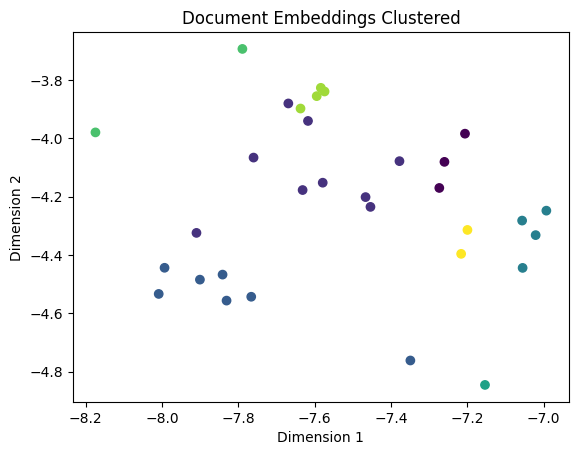

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(document_vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Document Embeddings Clustered')
plt.show()

In [59]:
# Find the closest embeddings to the centroids

# Create an empty list for closest points
closest_indices = []

# Loop through the number of clusters 
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(document_vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [75]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 4, 7, 13, 17, 21, 24, 28]

In [83]:
print(len(pages))
#for selectedidx in selected_indices:
#    print (pages[selectedidx].page_content)

#pages

#selected_pages = [pages[pageidx] for pageidx in selected_indices]
#print (selected_pages)
#print (len(selected_pages))

#selected_pages_content = ""
#selected_pages_content += [page.page_content for page in selected_pages]

25


In [68]:
#create summarization chain
summary_chain = load_summarize_chain(llm=llm, chain_type='stuff',verbose=False )

In [69]:
#run summarization chain on selected pages
sum = summary_chain.run(selected_pages)

display(HTML(sum))

InvalidRequestError: This model's maximum context length is 4097 tokens, however you requested 5952 tokens (5696 in your prompt; 256 for the completion). Please reduce your prompt; or completion length.